### Calculate scoring rate + the probability distribution of time elapsed between scoring events

* work with one game first

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
sample = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\pbp_games\g201410290PHO.csv")
sample.head (10)

,time,away_description,away_change,score,home_change,home_description
0,11:43.0,,,0-2,+2,M. Plumlee makes 2-pt dunk at rim (assist by E...
1,11:28.0,K. Bryant misses 2-pt jump shot from 16 ft,,0-2,,
2,11:26.0,Offensive rebound by Team,,0-2,,
3,11:25.0,,,0-2,,Violation by M. Plumlee (def goaltending)
4,11:25.0,C. Boozer makes 2-pt layup from 2 ft (assist b...,+2,2-2,,
5,11:03.0,,,2-5,+3,M. Morris makes 3-pt jump shot from 23 ft (ass...
6,10:51.0,J. Lin misses 2-pt jump shot from 19 ft,,2-5,,
7,10:49.0,Offensive rebound by J. Hill,,2-5,,
8,10:43.0,C. Boozer misses 2-pt jump shot from 15 ft,,2-5,,
9,10:41.0,,,2-5,,Defensive rebound by M. Plumlee


* ignore OTs

In [59]:
quarter = [0]*len(sample)
quarter [0] = 1
qt_count = 1

for i in range (1, len(sample)):
    secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
    secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
    if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
        print (sample['time'][i-1], sample['time'][i])
        qt_count +=1 
    quarter [i] = qt_count

sample ['quarter'] = quarter

In [55]:
sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)

In [56]:
sample.tail ()

,time,away_description,away_change,score,home_change,home_description,quarter,seconds
419,0:39.0,,,99-119,,Turnover by T. Ennis (lost ball; steal by R. P...,4,2841.0
420,0:35.0,R. Price misses 2-pt jump shot from 4 ft (bloc...,,99-119,,,4,2845.0
421,0:35.0,Offensive rebound by Team,,99-119,,,4,2845.0
422,0:24.0,R. Price misses 2-pt layup from 2 ft,,99-119,,,4,2856.0
423,0:22.0,,,99-119,,Defensive rebound by A. Tolliver,4,2858.0


In [37]:
score_dict = {} #key = seconds, value = points scored
for i in range (1, 2881):
    score_dict [i] = 0

In [ ]:
for i in range (len(sample)):
    home_score = 0
    away_score = 0
    if (sample['home_change'][i][0] == "+"):
        home_score += int(sample['home_change'][i][1])
    if (sample['away_change'][i][0] == "+"):
        away_score += int(sample['away_change'][i][1])
    score_dict [sample['seconds'][i]] += home_score + away_score

---

In [111]:
def time (sample):

    quarter = [0]*len(sample)
    quarter [0] = 1
    qt_count = 1

    for i in range (1, len(sample)):
        secs_prev = int (sample['time'][i-1].split(":")[0])*60+float (sample['time'][i-1].split(":")[1])
        secs_cur = int (sample['time'][i].split(":")[0])*60+float (sample['time'][i].split(":")[1])
        if (secs_cur - secs_prev >= 60): # no way 60s is added back on the clock
            # print (sample['time'][i-1], sample['time'][i])
            qt_count +=1 
        quarter [i] = qt_count
    sample ['quarter'] = quarter
    sample ['seconds'] = sample.apply (lambda x: x.quarter*12*60 - int(x.time.split(":")[0])*60
                                             - float(x.time.split(":")[1]), axis = 1)
    sample = sample [sample['quarter']<=4]
    return sample

In [112]:
score_dict_home = [0]*2881
time_elapsed_home = [0]*2881
scoring_plays_home = [0]*2881
scoring_decomp_home = [0]*7

score_dict_away = [0]*2881
time_elapsed_away = [0]*2881
scoring_plays_away = [0]*2881
scoring_decomp_away = [0]*7

atp_denom = 0
atp_num = 0

lead_changes_dist = []
scoring_pos_dist = []
points_dist_home = []
points_dist_away = []

In [113]:
lead_dic_num = {}
lead_dic_denom = {}
for i in range (1, 100):
    lead_dic_num [i] = 0
    lead_dic_denom [i] = 0

In [140]:
def get_stats (sample):

    prev_time_home = 0
    prev_value_home = 0
    times_home = [0]
    scores_home = [0]
    prev_time_away = 0
    prev_value_away = 0
    times_away = [0]
    scores_away = [0]
    lead = ""
    lead_change_ct = 0
    differential = {}

    for i in range (len(sample)):

        cur_home = int (sample['score'][i].split("-")[0])
        cur_away = int (sample['score'][i].split("-")[1])

        if (cur_home>cur_away):
            if (lead==""):
                lead = "home"
            elif (lead=="away"):
                lead = "home"
                lead_change_ct +=1
        elif (cur_away>cur_home):
            if (lead==""):
                lead = "away"
            elif (lead=="home"):
                lead = "away"
                lead_change_ct +=1
                
        differential [int(sample['seconds'][i])] = cur_home - cur_away
        
        if (i==len(sample)-1):
            points_dist_home.append (cur_home)
            points_dist_away.append (cur_away)

        if (len(sample['home_change'][i])>0 and sample['home_change'][i][0] == "+"):

            if (int(sample['seconds'][i])):
                delta = int(sample['home_change'][i][1])
                cur_time = int(sample['seconds'][i])
                score_dict_home [cur_time] += delta

            if (sample['seconds'][i] == prev_time_home):
                prev_value_home += delta #accounting for foul shot makes
                
            else: #ignore the initial case
                times_home.append (int(prev_time_home))
                scores_home.append (prev_value_home)
                prev_time_home = sample['seconds'][i]
                prev_value_home = delta
        
        if (len(sample['away_change'][i])>0 and sample['away_change'][i][0] == "+"):

            if (int(sample['seconds'][i])): 
                delta = int(sample['away_change'][i][1])
                cur_time = int(sample['seconds'][i])
                score_dict_away [cur_time] += delta

            if (sample['seconds'][i] == prev_time_away):
                prev_value_away += delta #accounting for foul shot makes
                
            else: #ignore the initial case
                times_away.append (int(prev_time_away))
                scores_away.append (prev_value_away)
                prev_time_away = sample['seconds'][i]
                prev_value_away = delta
    
    #last scoring procession - no next one - need to be added manually
    times_home.append (int(prev_time_home))
    scores_home.append (prev_value_home)
    
    for i in range (1, len(times_home)):
        time_elapsed_home [times_home[i]-times_home[i-1]] +=1
        scoring_decomp_home [scores_home[i]] +=1
        scoring_plays_home [times_home[i]] +=1

    times_away.append (int(prev_time_away))
    scores_away.append (prev_value_away)
    
    for i in range (1, len(times_away)):
        time_elapsed_away [times_away[i]-times_away[i-1]] +=1
        scoring_decomp_away [scores_away[i]] +=1
        scoring_plays_away [times_away[i]] +=1

    atp_denom = 0
    atp_num = 0

    """
    pop the one at the start and pop the one added for the first scoring possession
    """

    scores_home.pop (0)
    scores_away.pop (0)
    times_home.pop (0)
    times_away.pop (0)
    scores_home.pop (0)
    scores_away.pop (0)
    times_home.pop (0)
    times_away.pop (0)

    dic = {}
    for tm in times_home:
        dic [tm] = 1
    for tm in times_away:
        dic [tm] = -1
    scoring_merged = sorted (times_home+times_away)
    prev = 0
    
    for i in range (0, len(scoring_merged)):
        if (prev==0):
            prev = dic[scoring_merged[i]]
        else:
            atp_denom+=1
            if (prev == dic[scoring_merged[i]]):
                atp_num+=1
            prev = dic[scoring_merged[i]]
        if (abs(differential[scoring_merged[i]])>0):
            lead_size = abs(differential[scoring_merged[i]])
            in_the_lead = 0
            if (differential[scoring_merged[i]]>0):
                in_the_lead = 1
            else:
                in_the_lead = -1
            lead_dic_denom [lead_size] +=1
            if (i+1<len(scoring_merged)):
                if (dic[scoring_merged[i+1]] == in_the_lead): #next team that scores is the same as the team in the lead
                    lead_dic_num [lead_size] +=1
    
    scoring_pos_dist.append (len(times_home)+len(times_away)) #total # of scoring plays / game
    lead_changes_dist.append (lead_change_ct)

    return atp_num, atp_denom


In [141]:
games = pd.read_csv (r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\game_schedule.csv")

In [142]:
for i in range (len(games)):
    if (i%100 == 0):
        print (str(int(i/100))+"%", end=" ")
    path = "g"+games['id'][i]+".csv"
    # print (path)
    game = pd.read_csv (path)
    game = time (game)
    num, denom = get_stats (game)
    atp_num += num
    atp_denom += denom

0% 1% 2% 3% 4% 5% 6% 7% 8% 9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99% 100% 101% 

In [18]:
sec = []
for i in range (0, 2881):
    sec.append (i)

---
### Initial Look

In [143]:
scoring_plays_either = np.array(scoring_plays_home) + np.array(scoring_plays_away)
time_elapsed_either =  np.array(time_elapsed_home) +  np.array(time_elapsed_away)
scoring_decomp_tot =  np.array(scoring_decomp_home) +  np.array(scoring_decomp_away)

In [144]:
print (scoring_decomp_tot)

[ 20414  71744 671143 251257   1948     25      1]


In [145]:
scoring_time_prob = np.log (time_elapsed_either / np.sum(time_elapsed_either))

C:\Users\Bryant Xia\AppData\Local\Temp\ipykernel_9476\2910900034.py:1: RuntimeWarning: divide by zero encountered in log
  scoring_time_prob = np.log (time_elapsed_either / np.sum(time_elapsed_either))


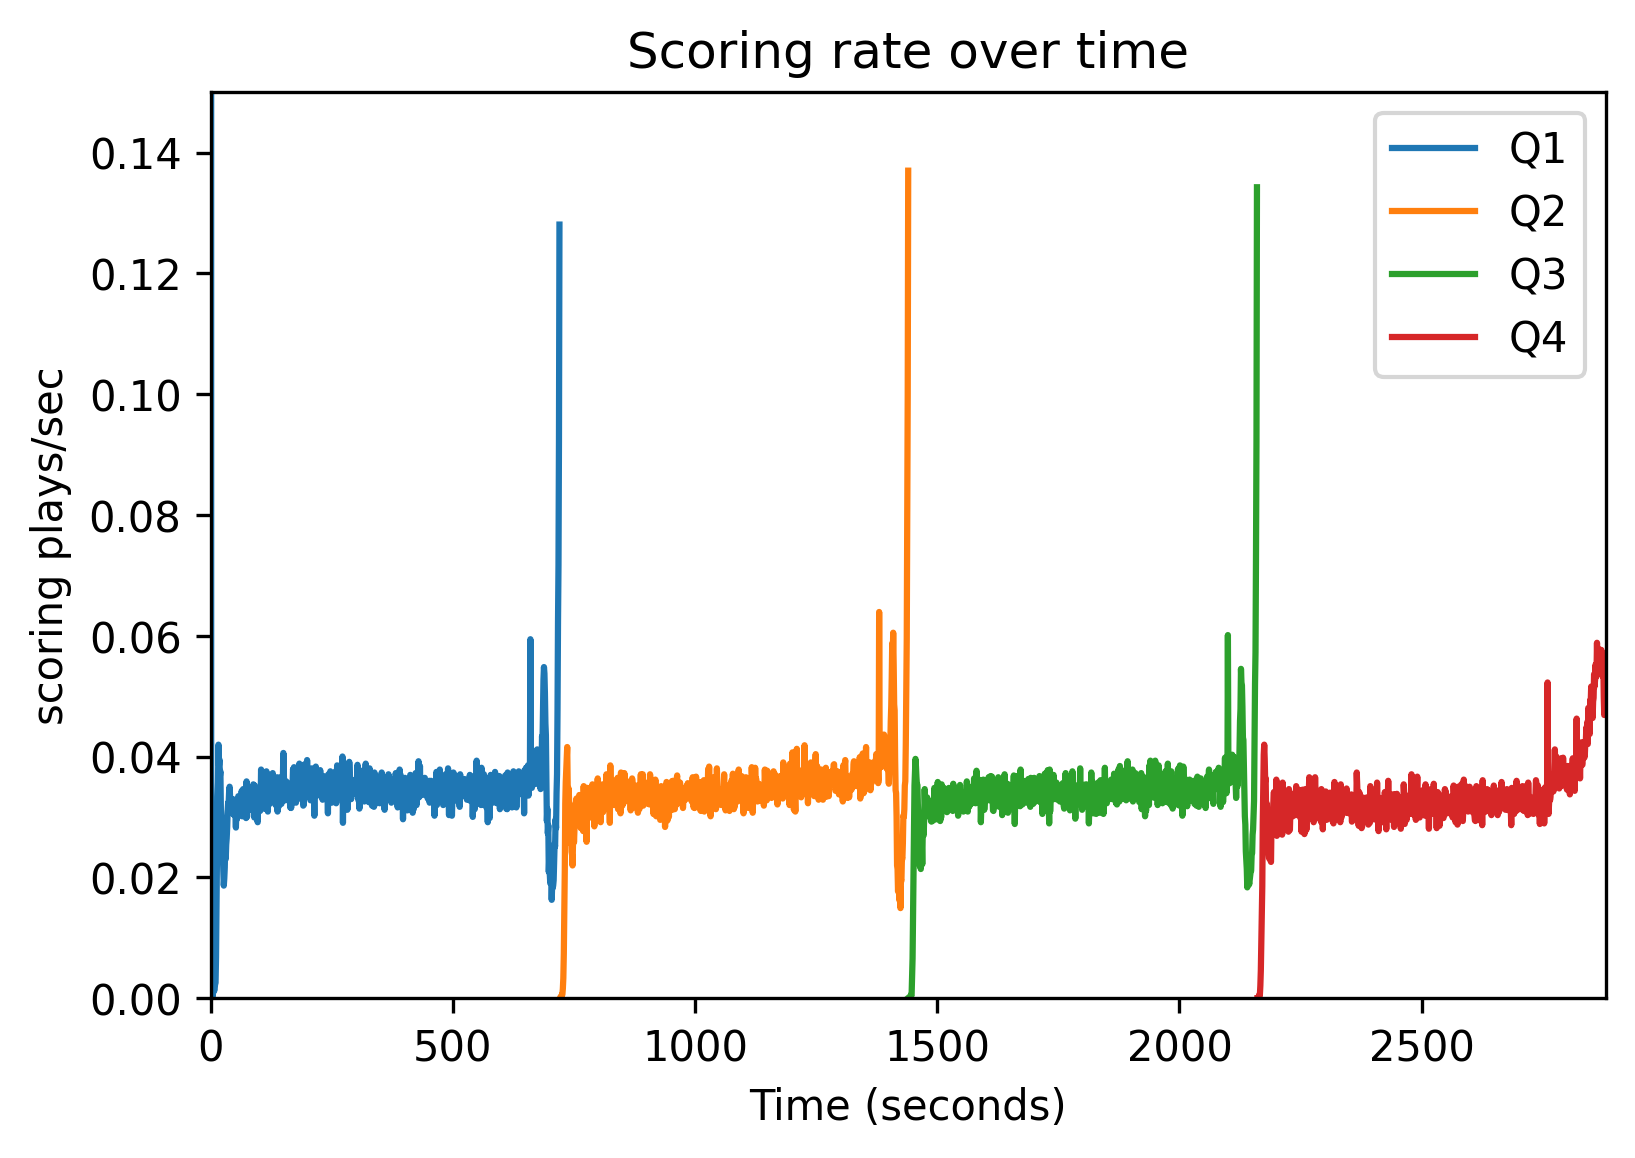

In [146]:
plt.figure (dpi=300)
plt.title ("Scoring rate over time")
plt.ylim ([0, 0.15])
plt.xlim([0, 2880])
plt.plot (sec[0:721], (scoring_plays_either/len(games))[0:721], label ="Q1")
plt.plot (sec[721:1441], (scoring_plays_either/len(games))[721:1441], label ="Q2")
plt.plot (sec[1441:2161], (scoring_plays_either/len(games))[1441:2161], label ="Q3")
plt.plot (sec[2161:], (scoring_plays_either/len(games))[2161:], label ="Q4")
plt.legend ()
plt.xlabel ("Time (seconds)")
plt.ylabel ("scoring plays/sec")
plt.savefig(r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\figures\scoring_rate.png")

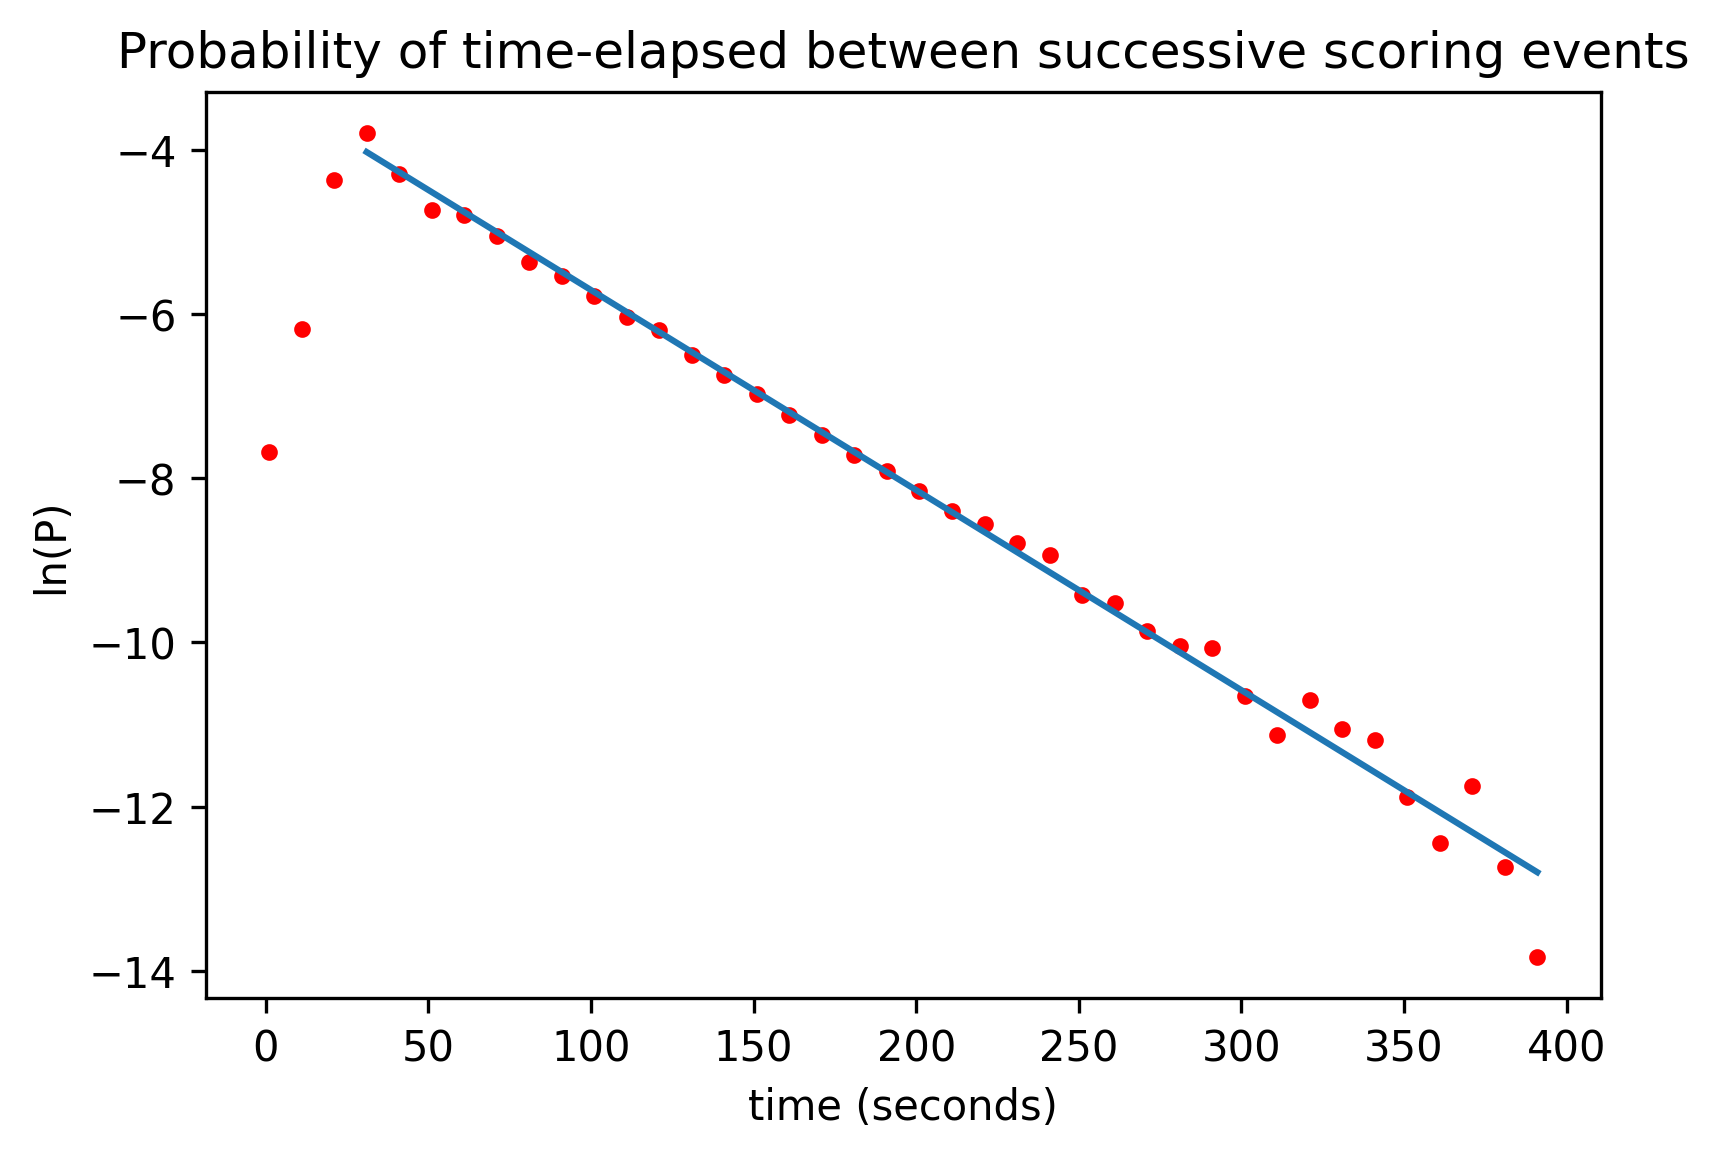

In [147]:
from sklearn.linear_model import LinearRegression

model = LinearRegression ()
X_fit = np.array (sec[31:400:10]).reshape (-1, 1)
Y_fit = np.array (scoring_time_prob[31:400:10]).reshape (-1, 1)
model.fit (X_fit, Y_fit)
y_pred = model.predict (np.array(sec[31:400:10]).reshape (-1, 1))

plt.figure (dpi=300)
plt.title ("Probability of time-elapsed between successive scoring events")
plt.xlabel ("time (seconds)")
plt.ylabel ("ln(P)")
plt.scatter (sec[1:400:10], scoring_time_prob[1:400:10], marker=".", color="red")
plt.plot (sec[31:400:10], y_pred)
plt.savefig(r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\figures\delta_t_prob.png")

* Linear on log scale -> exponential distribution of waiting time

In [148]:
scoring_decomp_pct = scoring_decomp_tot / np.sum (scoring_decomp_tot)
for i in range (1, len(scoring_decomp_pct)):
    print (i, "pts: ", str(scoring_decomp_pct [i]*100)+"%")

1 pts:  7.057721744126106%
2 pts:  66.02281089036056%
3 pts:  24.717077278432946%
4 pts:  0.1916319407554312%
5 pts:  0.0024593421554855136%
6 pts:  9.837368621942055e-05%


In [149]:
print ("scoring_rate: ",  np.mean(scoring_plays_either)/len(games))

scoring_rate:  0.03460233265822615


In [150]:
avg_pts = 0 

for i in range (1, len(scoring_decomp_pct)):
    avg_pts += i*scoring_decomp_pct [i]

print ("avg. points per scoring play: ",  avg_pts)

avg. points per scoring play:  2.1403399007606256


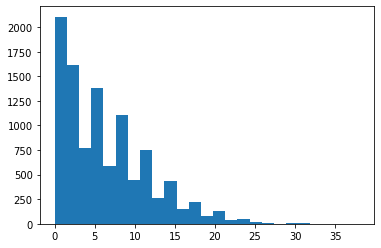

In [151]:
plt.hist (lead_changes_dist, bins = 25)
plt.show ()

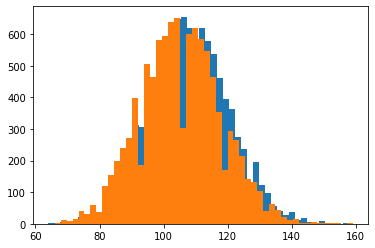

In [153]:
plt.hist (points_dist_away, bins = 50)
plt.hist (points_dist_home, bins = 50)
plt.show ()

In [154]:
anti_persistence = atp_num / atp_denom
print (anti_persistence)

0.3500930437016064


In [155]:
print (lead_dic_denom)

{1: 82469, 2: 88593, 3: 79119, 4: 72722, 5: 67312, 6: 61871, 7: 55677, 8: 51106, 9: 45749, 10: 41240, 11: 36730, 12: 33032, 13: 29466, 14: 26025, 15: 23356, 16: 20562, 17: 18099, 18: 16041, 19: 14059, 20: 12151, 21: 10621, 22: 9263, 23: 8061, 24: 6903, 25: 6110, 26: 5146, 27: 4442, 28: 3770, 29: 3241, 30: 2806, 31: 2274, 32: 2013, 33: 1684, 34: 1462, 35: 1214, 36: 1062, 37: 809, 38: 700, 39: 563, 40: 450, 41: 363, 42: 296, 43: 244, 44: 202, 45: 147, 46: 141, 47: 112, 48: 76, 49: 84, 50: 56, 51: 50, 52: 42, 53: 29, 54: 17, 55: 19, 56: 13, 57: 11, 58: 19, 59: 9, 60: 8, 61: 10, 62: 2, 63: 7, 64: 1, 65: 3, 66: 1, 67: 1, 68: 2, 69: 0, 70: 2, 71: 0, 72: 1, 73: 3, 74: 2, 75: 3, 76: 2, 77: 0, 78: 2, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 0, 85: 0, 86: 0, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 0, 94: 0, 95: 0, 96: 0, 97: 0, 98: 0, 99: 0}


---

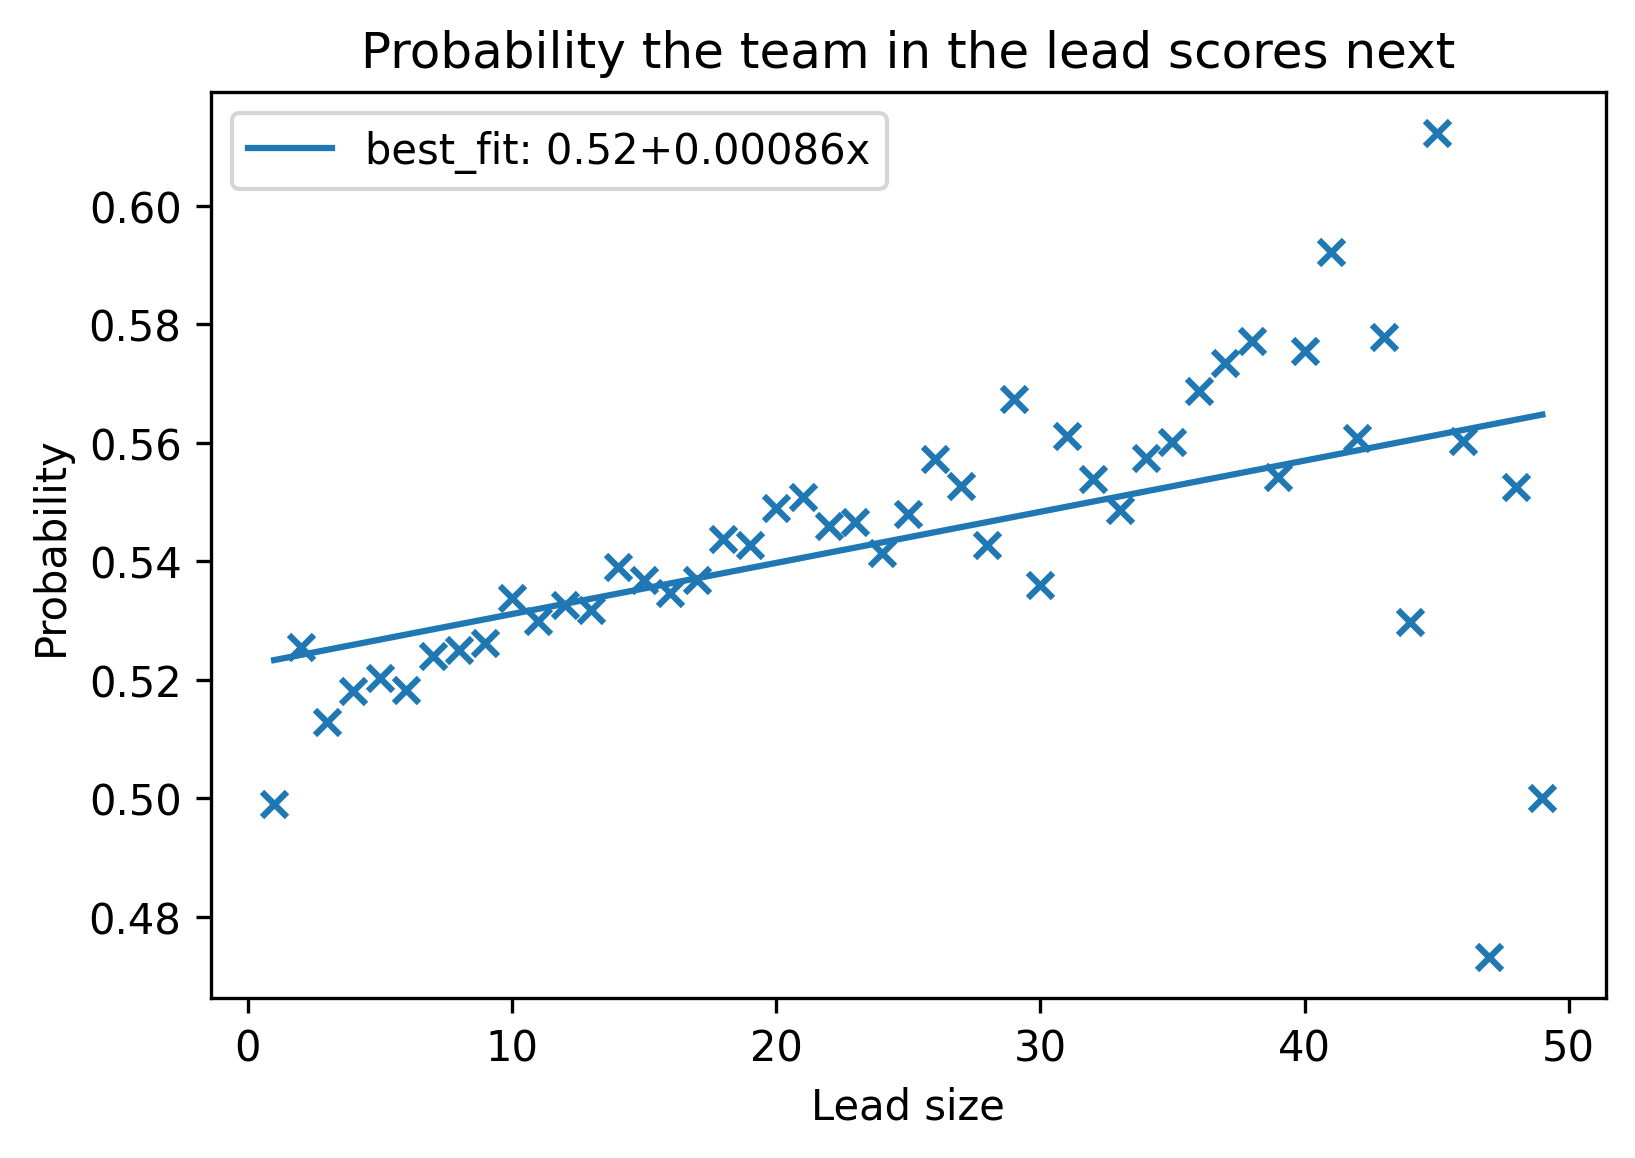

In [178]:
lead_sizes = []
lead_scoring_prob = []
for i in range (1, 50):
    lead_sizes.append (i)
    lead_scoring_prob.append (lead_dic_num[i]/lead_dic_denom[i])
model = LinearRegression ()
model.fit (np.array(lead_sizes).reshape (-1, 1), np.array(lead_scoring_prob).reshape (-1, 1))
y_pred = model.predict (np.array(lead_sizes).reshape (-1, 1))
plt.figure (dpi=300)
plt.plot (lead_sizes, y_pred, label="best_fit: 0.52+0.00086x")
plt.scatter (lead_sizes, lead_scoring_prob, marker = "x")
plt.legend ()
plt.title ("Probability the team in the lead scores next")
plt.ylabel ("Probability")
plt.xlabel ("Lead size")
plt.savefig(r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\figures\restoring_force.png")
plt.show ()

In [176]:
import plotly.express as px
df = pd.DataFrame ({"# of lead changes": lead_changes_dist})
fig = px.ecdf(df, x="# of lead changes")
fig.show()
fig.write_image(r"C:\Users\Bryant Xia\Desktop\lead_change_analysis\figures\lead_change_ecdf.png")

ValueError: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido


In [177]:
np.mean(np.array(scoring_pos_dist))

97.59909777385505